In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib import pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
def generate_sine_data():
    x = np.linspace(0, 100, 10000)
    sine = np.sin(x)
    sine = sine.reshape(x.shape[0], 1)
    return sine


def split_data(data, time_steps, test_ratio=0.3):
    n_train = int(len(data) * (1 - test_ratio))
    train = data[0:n_train]
    test = data[n_train:]
    test = np.vstack((train[-time_steps:], test))
    return train, test


def generate_rnn_data(data, time_steps, labels=False):
    rnn_data = []
    if labels:
        for i in range(len(data) - time_steps):
            rnn_data.append(data[i + time_steps])
    else:
        for i in range(len(data) - time_steps):
            rnn_data.append(data[i : i + time_steps])
    
    rnn_data = np.array(rnn_data)
    return rnn_data

def prepare_data(time_steps):
    raw_data = generate_sine_data()
    train, test = split_data(raw_data, time_steps, test_ratio=0.3)
    train_X = generate_rnn_data(train, time_steps, labels=False)
    test_X = generate_rnn_data(test, time_steps, labels=False)
    train_y = generate_rnn_data(train, time_steps, labels=True)
    test_y = generate_rnn_data(test, time_steps, labels=True)
    return train_X, test_X, train_y, test_y

In [ ]:
train_X, test_X, train_y, test_y = prepare_data(5)
sine = generate_sine_data()


In [16]:
LSTM_SIZE = 10
BATCH_SIZE = 200
TIME_STEPS = 20
N_FEATURES = 1
N_OUTPUTS = 1
LEARNING_RATE = 0.0001
CHECKPOINT_FOLDER = "tf/models/"

def simple_rnn(features, targets, mode, params):
    

    X = features['raw_data']
    X = tf.transpose(X, (1, 0, 2))
    X = tf.unstack(X)


    lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
    outputs, _ = rnn.static_rnn(lstm_cell, X, dtype=tf.float32)    
    outputs = outputs[-1]
    weights = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
    bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
    predictions = tf.matmul(outputs, weights) + bias
    predictions_dict = {"predicted": predictions}


    loss = tf.losses.mean_squared_error(targets, predictions)
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(targets, predictions)
    }

    
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params['learning_rate'],
        optimizer='SGD')
    
    return tflearn.ModelFnOps(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [17]:
def main():
    model_params = {"learning_rate": LEARNING_RATE}
    
    train_X, test_X, train_y, test_y = prepare_data(5)
    
    
    def get_train_inputs():
        #X = np.transpose(train_X, (1, 0, 2))
        X = tf.convert_to_tensor(train_X, dtype=tf.float32)
        y = tf.convert_to_tensor(train_y, dtype=tf.float32)
        return {'raw_data': X}, y
    
    def get_test_inputs():
        #X = np.transpose(test_X, (1, 0, 2))
        X = tf.convert_to_tensor(test_X, dtype=tf.float32)
        y = tf.convert_to_tensor(test_y, dtype=tf.float32)
        return {'raw_data': X}, y
        
    nn = tf.contrib.learn.Estimator(model_fn=simple_rnn, params=model_params, model_dir=CHECKPOINT_FOLDER)
    validation_monitor = tflearn.monitors.ValidationMonitor(input_fn=get_test_inputs,
                                                      every_n_steps=50, eval_steps=1)
    
    nn.fit(input_fn=get_train_inputs, steps=2000, monitors=[validation_monitor])
    ev = nn.evaluate(input_fn=get_test_inputs, steps=1)
    print("Loss: %s" % ev["loss"])
    print("Root Mean Squared Error: %s" % ev["rmse"])
    
    predictions = nn.predict(input_fn=get_test_inputs, as_iterable=False)
    print(predictions['predicted'].shape)
    print(test_y.shape)
    plt.plot(predictions['predicted'])
    plt.plot(test_y)
    plt.show()
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x122228c88>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'tf/models/'}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tf/models/model.ckpt.
INFO:tensorflow:loss = 0.661617, step = 1
INFO:tensorflow:Starting evaluation at 2017-07-03-05:54:33
INFO:tensorflow:Restoring parameters from tf/models/model.ckp

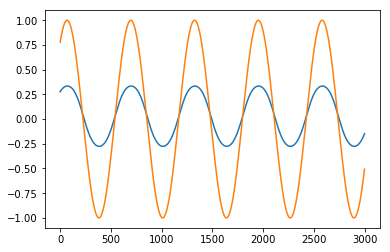

In [18]:
if __name__ == "__main__":
    main()